
#### <center> Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

### <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам <br> Неделя 2. Подготовка и первичный анализ данных

На второй неделе мы продолжим подготавливать данные для дальнейшего анализа и построения прогнозных моделей. Конкретно, раньше мы определили что сессия – это последовательность из 10 посещенных пользователем сайтов, теперь сделаем длину сессии параметром, и потом при обучении прогнозных моделей выберем лучшую длину сессии.
Также мы познакомимся с предобработанными данными и статистически проверим первые гипотезы, связанные с нашими наблюдениями. 

**План 2 недели:**
 - Часть 1. Подготовка нескольких обучающих выборок для сравнения
 - Часть 2. Первичный анализ данных, проверка гипотез

## Часть 1. Подготовка нескольких обучающих выборок для сравнения

Пока мы брали последовательности из 10 сайтов, и это было наобум. Давайте сделаем число сайтов в сессии параметром, чтоб в дальнейшем сравнить модели классификации, обученные на разных выборках – с 5, 7, 10 и 15 сайтами в сессии. Более того, пока мы брали по 10 сайтов подряд, без пересечения. Теперь давайте применим идею скользящего окна – сессии будут перекрываться. 

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

Создадим несколько выборок для разных сочетаний параметров длины сессии и ширины окна. Все они представлены в табличке ниже:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Итого должно получиться 18 разреженных матриц – указанные в таблице 9 сочетаний параметров формирования сессий для выборок из 10 и 150 пользователей. При этом 2 выборки мы уже сделали в прошлой части, они соответствуют сочетанию параметров: session_length=10, window_size=10, которые помечены в таблице выше галочкой зеленого цвета (done).

Реализуйте функцию *prepare_sparse_train_set_window*.

Аргументы:
- *path_to_csv_files* – путь к каталогу с csv-файлами
- *site_freq_path* – путь к pickle-файлу с частотным словарем, полученным в 1 части проекта
- *session_length* – длина сессии (параметр)
- *window_size* – ширина окна (параметр) 

Функция должна возвращать 2 объекта:
- разреженную матрицу *X_sparse* (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из *session_length* сайтов, а *max(site_id)* столбцов – количеству посещений *site_id* в сессии. 
- вектор *y* (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из *X_sparse*

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
def write_answer_to_file(answer, textfile):
    with open(textfile, 'w') as fout:
        fout.write(str(answer))

In [3]:
#путь к данным
PATH_TO_DATA = 'capstone_user_identification' 

In [4]:
#создание функции, которая подготавливает данные data, indices, indptr для csr_matrix 
def data_for_csr_matrix(data):
    indptr = [0]
    indices = []
    sparse_data = []
    vocabulary = {}
    for d in data:
        for term in d:
            if term!=0:
                index = vocabulary.setdefault(term, len(vocabulary))
                indices.append(index) 
                sparse_data.append(1)
        indptr.append(len(indices))
    return sparse_data, indices, indptr

In [5]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, session_length=10, window_size = 10):
    
    site_freq_dict = {} # частотный словарь
    data = [] #массив с индексами сайтов
    sites_seq = [] #список сайтов в сессии    
    user_ids = [] #массив id пользователей
    start_session_index = 0 #индекс начала следующей сессии в зависимости от ширины окна 
    
    #считывание частотного словаря из файла
    with open(site_freq_path, 'rb') as f:
        site_freq_dict = pickle.load(f)
      
    for user_id, path_to_file in enumerate(glob(path_to_csv_files + '/*.csv')):
        user_id += 1
        with open(path_to_file) as file: 
            lines = file.readlines()[1:]
            #заполнение списка сайтов сессии для пользователя
            for i, line in enumerate(lines):
                site = line.strip().split(',')[1]
                sites_seq.append(site)
                            
        #заполнение массива id сайтов
        while start_session_index < len(lines):
            session_end = len(lines)\
                if start_session_index + session_length > len(lines) - 1 \
                else start_session_index + session_length
                #если это последняя сессия пользователя, то ее длина может быть не равна session_length
                #в таком случаем происходит заполнение оставшихся индексов нулями
            sites_id = list(site_freq_dict[i][0] for i in sites_seq[start_session_index:session_end])\
                        +[0 for i in range(session_length - len(lines) + start_session_index)]
            
            data.append(sites_id)
            user_ids.append(user_id)
            start_session_index += window_size            
        
        start_session_index = 0  
        sites_seq = []
    
    sparse_matrix = csr_matrix(data_for_csr_matrix(data), dtype = int) 
    
    return sparse_matrix, user_ids

**Примените полученную функцию с параметрами *session_length=5* и *window_size=3* к игрушечному примеру. Убедитесь, что все работает как надо.**

In [6]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'3users'), 
                                                       os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'),
                                       session_length=5, window_size=3)

In [7]:
X_toy_s5_w3.todense()

matrix([[1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 3, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [8]:
y_s5_w3

[1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3]

**Запустите созданную функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150), значениям параметра *session_length* (15, 10, 7 или 5) и значениям параметра *window_size* (10, 7 или 5). Сериализуйте все 16 разреженных матриц (обучающие выборки) и векторов (метки целевого класса – ID пользователя) в файлы `X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl` и `y_{num_users}users_s{session_length}_w{window_size}.pkl`.**

**Чтоб убедиться, что мы все далее будем работать с идентичными объектами, запишите в список *data_lengths* число строк во всех полученных рареженных матрицах (16 значений). Если какие-то будут совпадать, это нормально (можно сообразить, почему).**

**На моем ноутбуке этот участок кода отработал за 26 секунд, хотя понятно, что все зависит от эффективности реализации функции *prepare_sparse_train_set_window* и мощности используемого железа. И честно говоря, моя первая реализация была намного менее эффективной (34 минуты), так что тут у Вас есть возможность оптимизировать свой код.**

In [10]:
%%time
import itertools

data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, '{}users'.format(num_users)), 
                                                          os.path.join(PATH_TO_DATA, 'site_freq_{}users.pkl'.format(num_users)),
                                                           session_length=session_length, 
                                                           window_size=window_size)
            file = os.path.join(PATH_TO_DATA, 'X_sparse_{}users_s{}_w{}.pkl'.format(num_users, session_length, window_size)) 
            with open(file, 'wb') as f:
                pickle.dump(X_sparse, f)
            file = os.path.join(PATH_TO_DATA, 'y_{}users_s{}_w{}.pkl'.format(num_users, session_length, window_size))
            with open(file,'wb') as f:
                pickle.dump(y, f)
            data_lengths.append(X_sparse.shape[0])

CPU times: user 15.7 s, sys: 464 ms, total: 16.2 s
Wall time: 16.5 s


**Запишите в файл *answer2_1.txt* все числа из списка *data_lengths* через пробел. Полученный файл будет ответом на 1 вопрос теста.**

In [11]:
data_lengths

[14061,
 20087,
 20087,
 20087,
 28118,
 28118,
 28118,
 28118,
 137019,
 195712,
 195712,
 195712,
 273957,
 273957,
 273957,
 273957]

In [12]:
write_answer_to_file(" ".join(str(i) for i in data_lengths), '2-1.txt')

## Часть 2. Первичный анализ данных, проверка гипотез

**Считаем в DataFrame подготовленный на 1 неделе файл `train_data_10users.csv`. Далее будем работать с ним.**

In [13]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [14]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,192,574,133,3,133,133,3,133,203,133,1
1,415,193,674,254,133,31,393,3305,217,55,1
2,55,3,55,55,5,293,415,333,897,55,1
3,473,3306,473,55,55,55,55,937,199,123,1
4,342,55,5,3307,258,211,3308,2086,675,2086,1


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   site1    14061 non-null  int64
 1   site2    14061 non-null  int64
 2   site3    14061 non-null  int64
 3   site4    14061 non-null  int64
 4   site5    14061 non-null  int64
 5   site6    14061 non-null  int64
 6   site7    14061 non-null  int64
 7   site8    14061 non-null  int64
 8   site9    14061 non-null  int64
 9   site10   14061 non-null  int64
 10  user_id  14061 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


**Распределение целевого класса:**

In [16]:
train_df['user_id'].value_counts()

5     2796
3     2204
9     1868
4     1712
10    1643
7     1022
6      802
1      760
8      720
2      534
Name: user_id, dtype: int64

**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [17]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [18]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

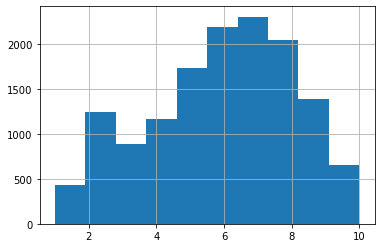

In [19]:
pd.Series(num_unique_sites).hist();

**Проверьте с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально. Сделайте вывод. Ответом на второй вопрос в тесте будет файл со словом "YES" или "NO" в зависимости от того, распределено ли нормально число уникальных сайтов в сессии.**

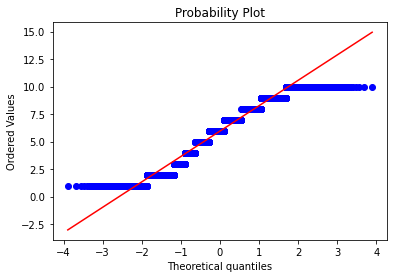

In [20]:
fig, ax = plt.subplots()
stats.probplot(num_unique_sites, plot = ax)
plt.show()

In [21]:
W, pi_val = stats.shapiro(num_unique_sites)
pi_val

0.0

In [22]:
write_answer_to_file('NO', '2-2.txt')

**Проверьте гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Давайте проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95% (обратите внимание, что альтернатива тому, что доля равна 95% –  одностороняя). Ответом на 3 вопрос в тесте будет полученное p-value.**

In [23]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
has_two_similar

array([1, 0, 1, ..., 1, 1, 1])

In [24]:
pi_val = stats.binom_test(has_two_similar.sum(), has_two_similar.shape[0], p=0.95)/2
pi_val

0.02209189603162069

In [25]:
write_answer_to_file(pi_val, 'answer2-3.txt')

**Постройте для этой доли 95% доверительный интервал Уилсона. Округлите границы интервала до 3 знаков после запятой и запишите через пробел в файл *answer2_4.txt*. Это будет ответом на 4 вопрос теста.**

In [26]:
wilson_interval = proportion_confint(has_two_similar.sum(), has_two_similar.shape[0], method='wilson')
wilson_interval

(0.9501028841411286, 0.9570527377232229)

In [27]:
write_answer_to_file('{} {}'.format(round(wilson_interval[0], 3),
                                   round(wilson_interval[1], 3)), 
                     '2-4.txt')

**Постройте распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.**

In [28]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), "rb") as fp:
    all_sites_dict = pickle.load(fp)
site_dict_1000 = [i[1] for i in all_sites_dict.values() if i[1]>999]
site_dict_1000

[8300,
 7813,
 5441,
 4158,
 4141,
 3758,
 3244,
 3094,
 2630,
 2089,
 1939,
 1868,
 1804,
 1702,
 1493,
 1441,
 1388,
 1265,
 1232,
 1204,
 1057,
 1041,
 1039,
 1039,
 1002]

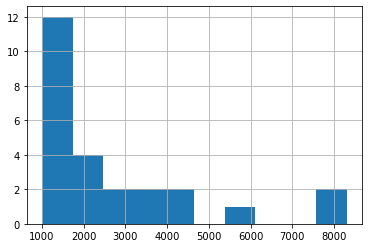

In [29]:
pd.Series(site_dict_1000).hist();

**Постройте 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap. Используйте столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям. Берите подвыборки из посчитанного списка частот посещений сайтов – не надо заново считать эти частоты. Учтите, что частоту появления нуля (сайт с индексом 0 появлялся там, где сессии были короче 10 сайтов) включать не надо. Округлите границы интервала до 3 знаков после запятой и запишите через пробел в файл *answer2_5.txt*. Это будет ответом на 5 вопрос теста.**

In [30]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [31]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

In [32]:
all_freq = np.array([i[1] for i in all_sites_dict.values()])
bootstrap_samples = list(map(np.mean, get_bootstrap_samples(all_freq, len(all_freq))))
conf_interval = stat_intervals(bootstrap_samples, 0.05)
conf_interval

array([22.51524527, 35.76303684])

In [33]:
write_answer_to_file('{} {}'.format(round(conf_interval[0], 3), round(conf_interval[1], 3)), 
                                    '2-5.txt')